###Conexão com o Drive para puxar o data set extraído do SISCAN.


In [1]:
from google.colab import drive
drive.mount('/content/drive/');

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###Downgrade do Numpy e Importação das libs.



In [2]:
!pip uninstall numpy -y

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [3]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 74.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9

In [1]:
!pip install pmdarima

  Using cached pmdarima-2.1.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.5 kB)
Using cached pmdarima-2.1.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (689 kB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from copy import deepcopy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action='ignore')

print(np.__version__)


1.26.4


###Leitura do data set.

In [3]:
mamografias_df = pd.read_csv('/content/drive/MyDrive/PI1/qtd_mamo_com_pandemia.csv', parse_dates=['DATE']);

#Primeiros e últimos 5 dados do data set.
print();
print('----------------- HEAD -----------------');
print(mamografias_df.head());
print();
print('----------------- TAIL -----------------');
print(mamografias_df.tail());


#Descrição estatística dos dados.
descricao_mamografias_df = mamografias_df.describe();
print();
print('-------------- DESCRICAO ---------------');
print(descricao_mamografias_df);


----------------- HEAD -----------------
        DATE  Exames  Pandemia
0 2018-02-01      33         0
1 2018-03-01     249         0
2 2018-04-01     653         0
3 2018-05-01     786         0
4 2018-06-01     583         0

----------------- TAIL -----------------
         DATE  Exames  Pandemia
87 2025-05-01    1687         0
88 2025-06-01    2152         0
89 2025-07-01    2254         0
90 2025-08-01    1680         0
91 2025-09-01    1484         0

-------------- DESCRICAO ---------------
                      DATE       Exames   Pandemia
count                   92    92.000000  92.000000
mean   2021-11-15 12:00:00  1411.989130   0.054348
min    2018-02-01 00:00:00    29.000000   0.000000
25%    2019-12-24 06:00:00  1003.750000   0.000000
50%    2021-11-16 00:00:00  1308.000000   0.000000
75%    2023-10-08 18:00:00  1694.250000   0.000000
max    2025-09-01 00:00:00  3380.000000   1.000000
std                    NaN   678.391933   0.227945


###Plotagem inicial

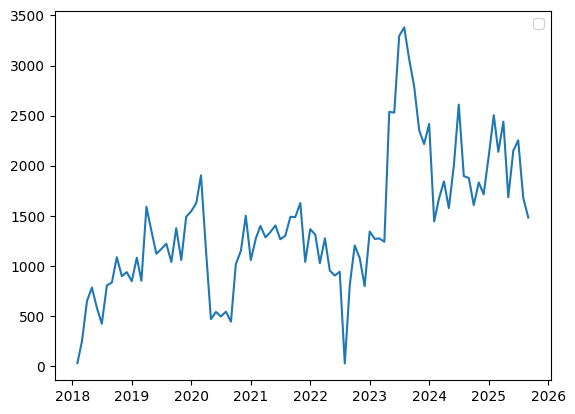

In [4]:
plt.figure();
plt.plot(mamografias_df['DATE'], mamografias_df['Exames']);
plt.legend();
plt.show();

###Separação dos dados em treino e teste


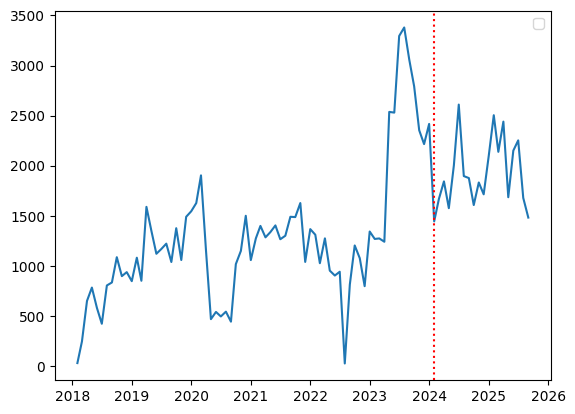

In [5]:
#Aqui vamos usar a regra dos 80/20, ou seja, 80% para treino 20% para teste:
#2018-01-01 até 2024-01-01 -> treino
#2024-02-01 até 2025-09-01 -> teste

DATA_MAX_TREINO = mamografias_df.iloc[72]['DATE'];

plt.figure();
plt.plot(mamografias_df['DATE'], mamografias_df['Exames']);
plt.axvline(DATA_MAX_TREINO, color='red', linestyle="dotted");
plt.legend();
plt.show();

df_treino = mamografias_df.loc[mamografias_df['DATE'] < DATA_MAX_TREINO, :];
df_teste = mamografias_df.loc[mamografias_df['DATE'] >= DATA_MAX_TREINO, :];


###Utilização do AutoARIMA para decidir os melhores parâmetros - **SEM** SESDF

In [6]:
auto_arima = pm.auto_arima(
    df_treino['Exames'],
    X=df_treino[['Pandemia']],
    m=12,
    seasonal=True,
    stepwise=True,
    trace=True
)

ordem_sarima_autoarima = auto_arima.order  #(p, d, q)
ordem_sazonal_autoarima  = auto_arima.seasonal_order  #(P, D, Q, 12)

variaveis_treino_endog_autoarima = df_treino['Exames']
variaveis_treino_exog_autoarima = df_treino[['Pandemia']]
variaveis_teste_exog_autoarima = df_teste[['Pandemia']]

print(f"Ordens SARIMAX encontradas: {ordem_sarima_autoarima}")
print(f"Ordens Sazonais encontradas: {ordem_sazonal_autoarima}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1035.546, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1034.588, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1032.826, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1034.232, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1033.801, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1034.502, Time=0.40 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1036.531, Time=0.26 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1035.514, Time=0.50 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1034.915, Time=0.48 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1033.866, Time=0.16 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : 

###Utilização do AutoARIMA para decidir os melhores parâmetros - **COM** SESDF (não rodar)

In [ ]:
auto_arima = pm.auto_arima(
    df_treino['Exames'],
    X=df_treino[['Pandemia','SESDF']],
    m=12,
    seasonal=True,
    stepwise=True,
    trace=True
)

ordem_sarima_autoarima = auto_arima.order  #(p, d, q)
ordem_sazonal_autoarima  = auto_arima.seasonal_order  #(P, D, Q, 12)

variaveis_treino_endog_autoarima = df_treino['Exames']
variaveis_treino_exog_autoarima = df_treino[['Pandemia','SESDF']]
variaveis_teste_exog_autoarima = df_teste[['Pandemia','SESDF']]

print(f"Ordens SARIMAX encontradas: {ordem_sarima_autoarima}")
print(f"Ordens Sazonais encontradas: {ordem_sazonal_autoarima}")

###Construção do modelo

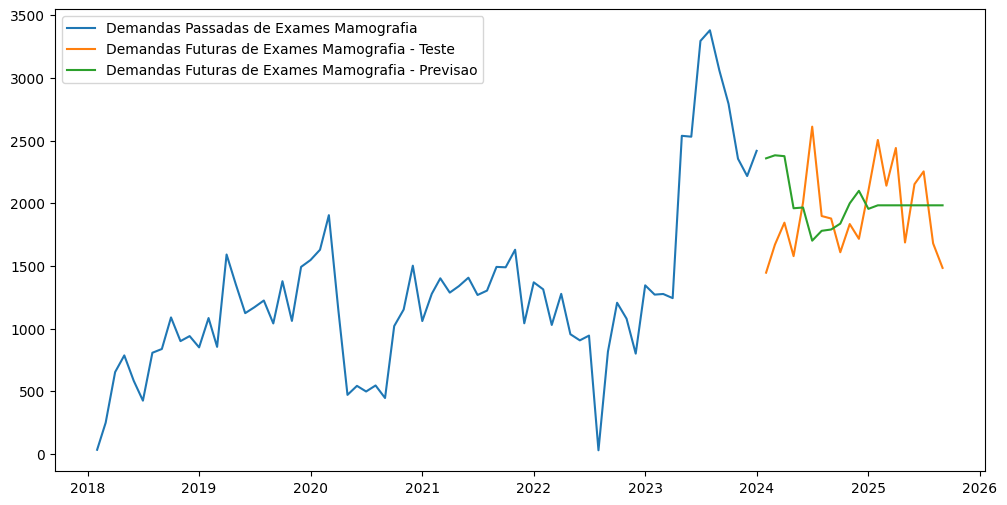

In [7]:
modelo = SARIMAX(
    endog = variaveis_treino_endog_autoarima,
    exog = variaveis_treino_exog_autoarima,
    order = ordem_sarima_autoarima,
    seasonal_order = ordem_sazonal_autoarima
).fit()

previsao = modelo.forecast(
    steps = len(df_teste),
    exog = variaveis_teste_exog_autoarima
)

plt.figure(figsize= (12,6));
plt.plot(df_treino['DATE'], df_treino['Exames'], label='Demandas Passadas de Exames Mamografia');
plt.plot(df_teste['DATE'], df_teste['Exames'], label='Demandas Futuras de Exames Mamografia - Teste');
plt.plot(df_teste['DATE'], previsao, label='Demandas Futuras de Exames Mamografia - Previsao');
plt.legend();
plt.show();

df_treino.to_csv("Demandas_Passadas_Exames_Mamografia.csv", index=False)
df_teste.to_csv("Demandas_Futuras_Exames_Mamografia_Teste.csv", index=False)
previsao_df = pd.DataFrame({
    "DATE": df_teste["DATE"].values,
    "Previsao": previsao.values
})
previsao_df.to_csv("Demandas_Futuras_Exames_Mamografia_Previsao.csv", index=False)

###Calculando a porcentagem de erro e eficácia da previsão do teste


In [8]:
y_real = df_teste['Exames']
y_prev = previsao

df_erros = pd.DataFrame({
    'Real': y_real,
    'Previsto': y_prev,
})
df_erros['Erro'] = df_erros['Real'] - df_erros['Previsto']            # erro bruto
df_erros['Erro_abs'] = df_erros['Erro'].abs()                         # erro absoluto
df_erros['Erro_%'] = (df_erros['Erro_abs'] / df_erros['Real']) * 100  # erro percentual

# Erro médio absoluto (MAE)
mae = mean_absolute_error(y_real, y_prev)

# Erro quadrático médio (RMSE)
rmse = np.sqrt(mean_squared_error(y_real, y_prev))

# Erro percentual médio (MAPE)
mape = np.mean(np.abs((y_real - y_prev) / y_real)) * 100

print('------------------------- DF DE ERROS -------------------------')
print(df_erros)
print()

print('------------------------- ERROS -------------------------')
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")





------------------------- DF DE ERROS -------------------------
    Real     Previsto        Erro    Erro_abs     Erro_%
72  1446  2358.260743 -912.260743  912.260743  63.088571
73  1670  2382.555355 -712.555355  712.555355  42.667985
74  1845  2375.513778 -530.513778  530.513778  28.754134
75  1578  1959.978295 -381.978295  381.978295  24.206483
76  2006  1965.975476   40.024524   40.024524   1.995240
77  2611  1701.412548  909.587452  909.587452  34.836747
78  1898  1780.000453  117.999547  117.999547   6.217047
79  1878  1790.566558   87.433442   87.433442   4.655668
80  1609  1837.268054 -228.268054  228.268054  14.186952
81  1834  1999.506095 -165.506095  165.506095   9.024324
82  1716  2099.053059 -383.053059  383.053059  22.322439
83  2099  1955.173884  143.826116  143.826116   6.852126
84  2505  1983.431862  521.568138  521.568138  20.821083
85  2140  1983.431862  156.568138  156.568138   7.316268
86  2441  1983.431862  457.568138  457.568138  18.745110
87  1687  1983.431862 -2

###Utilizando o modelo para prever o próximo ano

Última data histórica: 2025-09-01 00:00:00
Primeira data futura: 2025-10-01 00:00:00
Última data futura: 2026-09-01 00:00:00

DataFrame de previsão:
            Pandemia
DATE                
2025-10-01         0
2025-11-01         0
2025-12-01         0
2026-01-01         0
2026-02-01         0
            Pandemia
DATE                
2026-05-01         0
2026-06-01         0
2026-07-01         0
2026-08-01         0
2026-09-01         0

PREVISÃO FUTURA - PRÓXIMOS 5 ANOS

Primeiras 5 previsões:
        DATE  Previsao_Exames
0 2025-10-01      2358.260743
1 2025-11-01      2382.555355
2 2025-12-01      2375.513778
3 2026-01-01      1959.978295
4 2026-02-01      1965.975476

Últimas 5 previsões:
         DATE  Previsao_Exames
7  2026-05-01      1790.566558
8  2026-06-01      1837.268054
9  2026-07-01      1999.506095
10 2026-08-01      2099.053059
11 2026-09-01      1955.173884

✓ Arquivo salvo: previsao_1_ano.csv


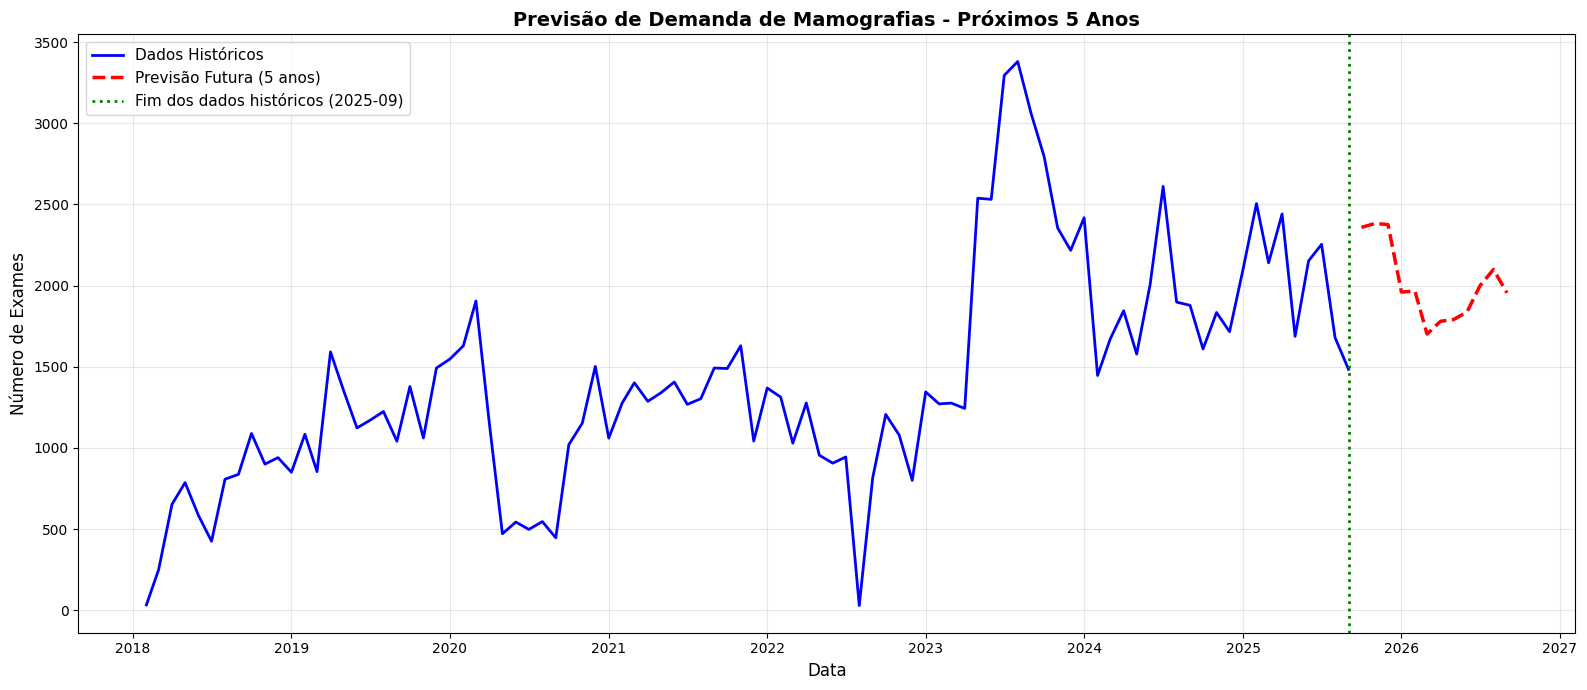


ESTATÍSTICAS DA PREVISÃO
Média prevista: 2017.11
Mínimo previsto: 1701.41
Máximo previsto: 2382.56
Desvio padrão: 240.20

PREVISÃO ANUAL MÉDIA
      Média Mensal  Total Anual   Mínimo   Máximo
Ano                                              
2025       2372.11      7116.33  2358.26  2382.56
2026       1898.77     17088.93  1701.41  2099.05


In [13]:
ultima_data = mamografias_df['DATE'].max()
print(f"Última data histórica: {ultima_data}")

datas_futuras = pd.date_range(
    start=ultima_data + pd.DateOffset(months=1),
    periods=12,  # 5 anos * 12 meses
    freq='MS'  # MS = Month Start (início do mês)
)

print(f"Primeira data futura: {datas_futuras[0]}")
print(f"Última data futura: {datas_futuras[-1]}")

previsao_df = pd.DataFrame({
    'DATE': datas_futuras,
    'Pandemia': 0,  # assumindo ausência de pandemia no futuro
})

previsao_df = previsao_df.set_index('DATE')

print("\nDataFrame de previsão:")
print(previsao_df.head())
print(previsao_df.tail())

nova_previsao = modelo.forecast(
    steps=len(previsao_df),
    exog=previsao_df[['Pandemia']]
)

resultado_df = pd.DataFrame({
    'DATE': datas_futuras,
    'Previsao_Exames': nova_previsao.values
})

print("\n" + "="*70)
print("PREVISÃO FUTURA - PRÓXIMO ANO")
print("="*70)
print("\nPrimeiras 5 previsões:")
print(resultado_df.head())
print("\nÚltimas 5 previsões:")
print(resultado_df.tail())

resultado_df.to_csv('/content/drive/MyDrive/PI1/previsao_1_ano.csv', index=False)
print("\n✓ Arquivo salvo: previsao_1_ano.csv")

plt.figure(figsize=(16, 7))

plt.plot(mamografias_df['DATE'], mamografias_df['Exames'],
         label='Dados Históricos', color='blue', linewidth=2)

plt.plot(resultado_df['DATE'], resultado_df['Previsao_Exames'],
         label='Previsão Futura (1 ano)', color='red', linewidth=2.5, linestyle='--')

plt.axvline(x=ultima_data, color='green', linestyle=':', linewidth=2,
            label=f'Fim dos dados históricos ({ultima_data.strftime("%Y-%m")})')

plt.xlabel('Data', fontsize=12)
plt.ylabel('Número de Exames', fontsize=12)
plt.title('Previsão de Demanda de Mamografias - Próximo Ano', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ESTATÍSTICAS DA PREVISÃO")
print("="*70)
print(f"Média prevista: {resultado_df['Previsao_Exames'].mean():.2f}")
print(f"Mínimo previsto: {resultado_df['Previsao_Exames'].min():.2f}")
print(f"Máximo previsto: {resultado_df['Previsao_Exames'].max():.2f}")
print(f"Desvio padrão: {resultado_df['Previsao_Exames'].std():.2f}")

print("\n" + "="*70)
print("PREVISÃO ANUAL MÉDIA")
print("="*70)
resultado_df['Ano'] = resultado_df['DATE'].dt.year
previsao_anual = resultado_df.groupby('Ano')['Previsao_Exames'].agg(['mean', 'sum', 'min', 'max'])
previsao_anual.columns = ['Média Mensal', 'Total Anual', 'Mínimo', 'Máximo']
print(previsao_anual.round(2))